In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import igraph
from supervenn import supervenn

In [2]:
data = pd.read_csv('/home/sv9t/transport_traffic.csv')

In [3]:
data.head()

,transport,departure,arrival,passengers
0,avia,Москва,Симферополь (Крым),159441
1,avia,Москва,Сочи,149299
2,avia,Симферополь (Крым),Москва,155822
3,avia,Сочи,Москва,143298
4,avia,Санкт-Петербург,Москва,135749


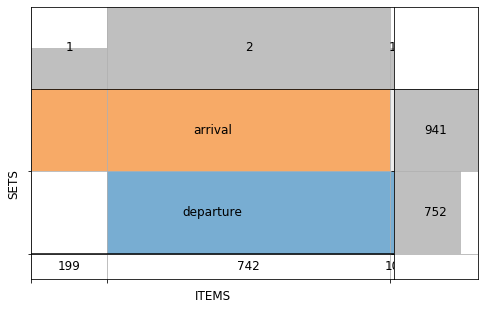

In [6]:
sets = [set(data['departure'].unique()), set(data['arrival'].unique())]
supervenn(sets, set_annotations=['departure', 'arrival'])

In [128]:
data['transport'].unique()

array(['avia', 'bus', 'train'], dtype=object)

In [8]:
all_names = set(data['departure'].unique()).union(data['arrival'].unique())

In [9]:
len(all_names)

951

In [10]:
name2id = {name: i for i, name in enumerate(all_names)}
id2name = {i: name for name, i in name2id.items()}

In [11]:
# For the first run sum all trasport types
grouped_df = data.groupby(['departure', 'arrival'])['passengers'].sum().reset_index()

In [12]:
grouped_df.head()

,departure,arrival,passengers
0,Абакан,Анапа,80
1,Абакан,Анжеро-Судженск,20
2,Абакан,Артышта,14
3,Абакан,Ачинск,374
4,Абакан,Барнаул,1151


In [13]:
grouped_df.shape

(15572, 3)

In [14]:
data.shape

(17388, 4)

# Init graph

In [94]:
edges = [(name2id[d], name2id[a]) for d, a in grouped_df[['departure', 'arrival']].values]

In [95]:
G = igraph.Graph(directed=True)

In [96]:
G.add_vertices(list(range(len(all_names))))

In [97]:
G.add_edges(edges)

In [98]:
G.es['weight'] = (grouped_df['passengers'] / 30).to_list()

In [99]:
G.summary()

'IGRAPH DNW- 951 15572 -- \n+ attr: name (v), weight (e)'

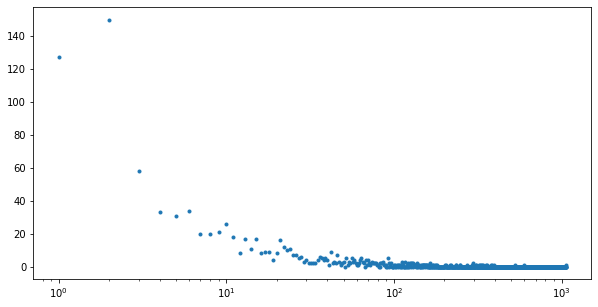

In [100]:
dd = G.degree_distribution()

bins = [b for b in dd.bins()]
plt.figure(figsize=(10, 5))
plt.scatter([l for l, r, b in bins], [b for l, r, b in bins], marker='.');
ax = plt.gca()
ax.set_xscale('log');

# SIR model

In [63]:
# Based on https://github.com/DmitrySerg/COVID-19/blob/master/models/COVID-19.ipynb
from scipy.integrate import odeint


class SIR():
    def __init__(self, pupulation, infected, recovered, beta, gamma):
        """
        N - Total population 
        I0 - Initial number of infected individuals, 
        S0 - Everyone else is susceptible to infection initially
        Contact rate, beta, and mean recovery rate, gamma, (in 1/days)
        """
        self.N = pupulation
        self.I0 = infected
        self.R = recovered
        self.beta = beta
        self.gamma = gamma
        self.S0 = pupulation - infected - recovered
#         self.days = days

    @staticmethod
    def _deriv(y, t, N, beta, gamma):
        """
        The SIR model differential equations
        """
        S, I, R = y
        dSdt = -beta[int(t)] * S * I / N
        dIdt = beta[int(t)] * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    def run(self, days):
        # Initial conditions vector
        y0 = [self.S0, self.I0, self.R]
        # Integrating the SIR equations over the time grid, t
        t = list(range(0, days))
        # Getting results
#         print(y0)
        result = odeint(self._deriv, y0, t, args=(self.N, self.beta, self.gamma))
        S, I, R = result.T
        return S, I, R

    @staticmethod
    def plot_results(S, I, R):
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, axisbelow=True)
        ax.plot(S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
        ax.plot(I/1000, 'r', alpha=0.5, lw=2, label='Infected')
        ax.plot(R/1000, 'g', alpha=0.5, lw=2, label='Recovered')
        ax.set_xlabel('Time /days')
        ax.set_ylabel('Number (1000s)')
        ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)
        ax.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)
        plt.show()

# City class

In [34]:
class City():
    def __init__(self, name, population, infected, recovered):
        self.name = name
        self.population = population
        self.infected = infected
        self.recovered = recovered
        
    def _sample_infected(self, n):
        # TODO: make it more realistic (maybe random sampled)
        # TODO: check if it sends more then exists
        return n * self.infected // self.population
    
    def _sample_recovered(self, n):
        # TODO: make it more realistic (maybe random sampled)
        # TODO: check if it sends more then exists
        return n * self.recovered // self.population
    
    def send_people(self, n):
        inf_t = self._sample_infected(n)
        rec_t = self._sample_recovered(n)
        self.infected -= inf_t
        self.recovered -= rec_t
        self.population -= n
        return inf_t, rec_t
        

# INIT Cities

### Real data

In [101]:
cities = pd.read_csv('../data/cities.csv')
cities.head()

,lat,lng,name,osm_accuracy,population
0,52.651055,90.101159,Абаза,0.593508,17111
1,53.720902,91.442435,Абакан,0.609791,165183
2,53.682800,53.655701,Абдулино,0.587183,20663
3,44.864953,38.157819,Абинск,0.597864,34926
4,56.525460,52.997251,Агрыз,0.596615,19299


In [118]:
name2population = {name: population for name, population in cities[['name', 'population']].values}

In [119]:
id2City = {i: City(name, name2population[name], 1, 0) for i, name in id2name.items()}

# Iters

In [120]:
# TODO: choose realistic numbers
contact_rate, recovery_rate = 10, 10

In [121]:
%%time
rows = []
def dumper(niter, cid, cname, s, i, r):
    rows.append((niter, cid, cname, s, i, r))

NITER = 10 # Days
for day in range(NITER):
    for city_id in G.vs:
        # update SIR
        city = id2City[city_id.index]

        sir = SIR(city.population, city.infected, city.recovered,
                  contact_rate, recovery_rate)
        S, I, R = sir.run(1)    
        city.infected = I[0]
        city.recovered = R[0]

        # save step result for sity
        dumper(day, city_id.index, city.name, S[0], I[0], R[0])

        # send
        # for every departure sample number of infected and recovered
    for city_id in G.vs:
        city = id2City[city_id.index]
        for dest_city_id in G.successors(city_id):
            edge_id = G.get_eid(city_id, dest_city_id)

            # TODO: split by individual vehicles
            ntravelers = G.es['weight'][edge_id]

            dest_city = id2City[dest_city_id]
            dest_city.population += ntravelers

            inf_t, rec_t = city.send_people(ntravelers)

            # receive
            dest_city.infected += inf_t
            dest_city.recovered += rec_t
        

CPU times: user 7.7 s, sys: 0 ns, total: 7.7 s
Wall time: 7.71 s


In [124]:
S, I, R

(array([26076.2]), array([-2.]), array([0.]))

In [123]:
rows[-10:]

[(9, 941, 'Алексин', 131831.09999999992, 19.0, 0.0),
 (9, 942, 'Пущино', 42926.400000000016, 10.0, 0.0),
 (9, 943, 'Пыталово', 5512.399999999998, 1.0, 0.0),
 (9, 944, 'Беломорск', 11575.09999999998, 1.0, 0.0),
 (9, 945, 'Елабуга', 70452.30000000006, 1.0, 0.0),
 (9, 946, 'Меленки', 15827.399999999992, 1.0, 0.0),
 (9, 947, 'Туапсе', 66475.10000000024, 42.0, 0.0),
 (9, 948, 'Болгар', 10150.500000000005, 1.0, 0.0),
 (9, 949, 'Новая Ляля', 13638.600000000002, 1.0, 0.0),
 (9, 950, 'Усть-Катав', 26076.200000000004, -2.0, 0.0)]

In [125]:
dumpdf = pd.DataFrame(rows, columns=['n_iter', 'city_id', 'name', 'suspected', 'infected', 'recovered'])

In [126]:
dumpdf.head()

,n_iter,city_id,name,suspected,infected,recovered
0,0,0,Коряжма,39628.0,1.0,0.0
1,0,1,Северобайкальск,23672.0,1.0,0.0
2,0,2,Кувандык,26175.0,1.0,0.0
3,0,3,Мама,14431.0,1.0,0.0
4,0,4,Новоабзаково,1330.0,1.0,0.0


In [127]:
dumpdf.to_csv('../data/dummy_sim_res.csv')